In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
os.listdir('/content/drive/MyDrive/datasets/FordA')

['FordA.txt',
 'FordA_TEST.txt',
 'FordA_TRAIN.txt',
 'FordA_TRAIN.arff',
 'FordA_TEST.arff',
 'FordA_TEST.ts',
 'FordA_TRAIN.ts',
 'generate_dataset',
 'transform_dataset']

In [ ]:
# ==============================================================================
# Step 1: Data Preprocessing
# ==============================================================================
import numpy as np
import os
from sklearn.preprocessing import StandardScaler

# Define data directory relative to Colab's environment
data_dir = r'/content/drive/MyDrive/datasets/FordA'
os.makedirs(data_dir, exist_ok=True)

# Function to load and preprocess the data
def load_forda(data_dir):
    """
    Loads, normalizes, and splits the FordA dataset into normal and abnormal
    data.
    """
    generate_dir = os.path.join(data_dir, 'generate_dataset')
    os.makedirs(generate_dir, exist_ok=True)

    # Note: The original files (FordA_TRAIN.txt, FordA_TEST.txt) are assumed
    # to be uploaded to the session's files or mounted from Google Drive.
    # You will need to upload these files manually.
    print("Please upload FordA_TRAIN.txt and FordA_TEST.txt to this session.")

    def read_ts_file(file_path):
        data = np.loadtxt(file_path)
        X = data[:, 1:]
        y = data[:, 0]
        return X, y

    X_train, y_train = read_ts_file(os.path.join(data_dir, 'FordA_TRAIN.txt'))
    X_test, y_test = read_ts_file(os.path.join(data_dir, 'FordA_TEST.txt'))

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    # Reshape for AMSL model
    X_train = X_train[:, :, np.newaxis]
    X_test = X_test[:, :, np.newaxis]

    normal_train = X_train[y_train == 1]
    normal_test = X_test[y_test == 1]
    abnormal_test = X_test[y_test == -1]

    np.save(os.path.join(generate_dir, 'normal_train.npy'), normal_train)
    np.save(os.path.join(generate_dir, 'normal_test.npy'), normal_test)
    np.save(os.path.join(generate_dir, 'abnormal_test.npy'), abnormal_test)

    print("Data preprocessing completed.")
    print(f"Normal Train: {normal_train.shape}, Normal Test: {normal_test.shape}, Abnormal Test: {abnormal_test.shape}")

# Run preprocessing
load_forda(data_dir)

# ==============================================================================
# Step 2: Data Transformation
# ==============================================================================
import random
from scipy.signal import savgol_filter
from sklearn.preprocessing import MinMaxScaler
import os

# Functions for transformations
def noised(signal):
    SNR = 5
    noise = np.random.randn(*signal.shape)
    noise = noise - np.mean(noise)
    signal_power = np.linalg.norm(signal)**2 / signal.size
    noise_variance = signal_power / np.power(10, SNR/10)
    noise = (np.sqrt(noise_variance) / np.std(noise)) * noise
    return signal + noise

def negated(signal):
    return signal * -1

def opposite_time(signal):
    return signal[:, ::-1, :]

def permuted(signal):
    window_size = 50
    sig = signal.copy()
    for i in range(0, signal.shape[1], window_size):
        indices = np.random.permutation(range(i, min(i + window_size, signal.shape[1])))
        sig[:, i:i + window_size, :] = signal[:, indices, :]
    return sig

def scale(signal):
    sc = random.choice([0.5, 2, 1.5, 0.8])
    return signal * sc

def time_warp(signal):
    for i in range(signal.shape[0]):
        signal[i, :, 0] = savgol_filter(signal[i, :, 0], window_length=11, polyorder=2)
    return signal

def regular_mm(data):
    scaler = MinMaxScaler()
    data_reshaped = data.reshape(data.shape[0], -1)
    data_scaled = scaler.fit_transform(data_reshaped)
    return data_scaled.reshape(data.shape)

def transformation(dataX):
    print("\nApplying transformations to data...")
    data_no = noised(dataX.copy())
    data_ne = negated(dataX.copy())
    data_op = opposite_time(dataX.copy())
    data_pe = permuted(dataX.copy())
    data_sc = scale(dataX.copy())
    data_ti = time_warp(dataX.copy())

    data_raw = regular_mm(dataX)
    data_no = regular_mm(data_no)
    data_ne = regular_mm(data_ne)
    data_op = regular_mm(data_op)
    data_pe = regular_mm(data_pe)
    data_sc = regular_mm(data_sc)
    data_ti = regular_mm(data_ti)

    data_raw = data_raw[:, :, :, np.newaxis]
    data_no = data_no[:, :, :, np.newaxis]
    data_ne = data_ne[:, :, :, np.newaxis]
    data_op = data_op[:, :, :, np.newaxis]
    data_pe = data_pe[:, :, :, np.newaxis]
    data_sc = data_sc[:, :, :, np.newaxis]
    data_ti = data_ti[:, :, :, np.newaxis]

    print("Data transformations applied.")
    return data_raw, data_no, data_ne, data_op, data_pe, data_sc, data_ti

def shuffle_and_save(normal_s_raw, normal_s_no, normal_s_ne, normal_s_op, normal_s_pe, normal_s_sc, normal_s_ti, path):
    listA = list(range(normal_s_raw.shape[0]))
    random.shuffle(listA)
    listB = list(range(normal_s_raw.shape[0]))

    dataset_raw = np.zeros_like(normal_s_raw)
    dataset_no = np.zeros_like(normal_s_no)
    dataset_ne = np.zeros_like(normal_s_ne)
    dataset_op = np.zeros_like(normal_s_op)
    dataset_pe = np.zeros_like(normal_s_pe)
    dataset_sc = np.zeros_like(normal_s_sc)
    dataset_ti = np.zeros_like(normal_s_ti)

    for w, r in zip(listA, listB):
        dataset_raw[r] = normal_s_raw[w]
        dataset_no[r] = normal_s_no[w]
        dataset_ne[r] = normal_s_ne[w]
        dataset_op[r] = normal_s_op[w]
        dataset_pe[r] = normal_s_pe[w]
        dataset_sc[r] = normal_s_sc[w]
        dataset_ti[r] = normal_s_ti[w]

    split_idx = int(dataset_raw.shape[0] * 0.6)
    X_train_raw, X_test_raw = dataset_raw[:split_idx], dataset_raw[split_idx:]
    X_train_no, X_test_no = dataset_no[:split_idx], dataset_no[split_idx:]
    X_train_ne, X_test_ne = dataset_ne[:split_idx], dataset_ne[split_idx:]
    X_train_op, X_test_op = dataset_op[:split_idx], dataset_op[split_idx:]
    X_train_pe, X_test_pe = dataset_pe[:split_idx], dataset_pe[split_idx:]
    X_train_sc, X_test_sc = dataset_sc[:split_idx], dataset_sc[split_idx:]
    X_train_ti, X_test_ti = dataset_ti[:split_idx], dataset_ti[split_idx:]

    os.makedirs(os.path.join(path, 'train_dataset'), exist_ok=True)
    os.makedirs(os.path.join(path, 'test_dataset/normal_data'), exist_ok=True)
    os.makedirs(os.path.join(path, 'test_dataset/abnormal_data'), exist_ok=True)

    np.save(os.path.join(path, "train_dataset/data_raw_train.npy"), X_train_raw)
    np.save(os.path.join(path, "train_dataset/data_no_train.npy"), X_train_no)
    np.save(os.path.join(path, "train_dataset/data_ne_train.npy"), X_train_ne)
    np.save(os.path.join(path, "train_dataset/data_op_train.npy"), X_train_op)
    np.save(os.path.join(path, "train_dataset/data_pe_train.npy"), X_train_pe)
    np.save(os.path.join(path, "train_dataset/data_sc_train.npy"), X_train_sc)
    np.save(os.path.join(path, "train_dataset/data_ti_train.npy"), X_train_ti)

    np.save(os.path.join(path, "test_dataset/normal_data/data_raw_test.npy"), X_test_raw)
    np.save(os.path.join(path, "test_dataset/normal_data/data_no_test.npy"), X_test_no)
    np.save(os.path.join(path, "test_dataset/normal_data/data_ne_test.npy"), X_test_ne)
    np.save(os.path.join(path, "test_dataset/normal_data/data_op_test.npy"), X_test_op)
    np.save(os.path.join(path, "test_dataset/normal_data/data_pe_test.npy"), X_test_pe)
    np.save(os.path.join(path, "test_dataset/normal_data/data_sc_test.npy"), X_test_sc)
    np.save(os.path.join(path, "test_dataset/normal_data/data_ti_test.npy"), X_test_ti)

    print("Normal data shuffled and saved successfully.")

# Run transformation process
data_path = r'/content/drive/MyDrive/datasets/FordA'
transform_path = os.path.join(data_path, 'transform_dataset')
os.makedirs(transform_path, exist_ok=True)

normal_train = np.load(os.path.join(data_path, "generate_dataset/normal_train.npy"))
normal_test = np.load(os.path.join(data_path, "generate_dataset/normal_test.npy"))
abnormal_test = np.load(os.path.join(data_path, "generate_dataset/abnormal_test.npy"))

normal = np.concatenate((normal_train, normal_test), axis=0)
number = normal.shape[0]
dataX = np.concatenate((normal, abnormal_test), axis=0)

data_raw, data_no, data_ne, data_op, data_pe, data_sc, data_ti = transformation(dataX)

data_raw_n = data_raw[:number]
data_no_n = data_no[:number]
data_ne_n = data_ne[:number]
data_op_n = data_op[:number]
data_pe_n = data_pe[:number]
data_sc_n = data_sc[:number]
data_ti_n = data_ti[:number]

data_raw_a = data_raw[number:]
data_no_a = data_no[number:]
data_ne_a = data_ne[number:]
data_op_a = data_op[number:]
data_pe_a = data_pe[number:]
data_sc_a = data_sc[number:]
data_ti_a = data_ti[number:]

shuffle_and_save(data_raw_n, data_no_n, data_ne_n, data_op_n, data_pe_n, data_sc_n, data_ti_n, transform_path)

# Save abnormal data separately
abnormal_dir = os.path.join(transform_path, "test_dataset/abnormal_data")
np.save(os.path.join(abnormal_dir, "data_raw_abnormal.npy"), data_raw_a)
np.save(os.path.join(abnormal_dir, "data_no_abnormal.npy"), data_no_a)
np.save(os.path.join(abnormal_dir, "data_ne_abnormal.npy"), data_ne_a)
np.save(os.path.join(abnormal_dir, "data_op_abnormal.npy"), data_op_a)
np.save(os.path.join(abnormal_dir, "data_pe_abnormal.npy"), data_pe_a)
np.save(os.path.join(abnormal_dir, "data_sc_abnormal.npy"), data_sc_a)
np.save(os.path.join(abnormal_dir, "data_ti_abnormal.npy"), data_ti_a)
print("Abnormal test data saved successfully.")




Please upload FordA_TRAIN.txt and FordA_TEST.txt to this session.
Data preprocessing completed.
Normal Train: (1755, 500, 1), Normal Test: (639, 500, 1), Abnormal Test: (681, 500, 1)

Applying transformations to data...
Data transformations applied.
Normal data shuffled and saved successfully.
Abnormal test data saved successfully.


In [ ]:
# ==============================================================================
# Step 3: Model Training
# ==============================================================================
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, Cropping2D, Dense, Dropout, Flatten, Concatenate, Multiply, Add, Lambda, TimeDistributed, ZeroPadding2D, BatchNormalization, Activation, Layer
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import backend as K
from tensorflow.keras.initializers import RandomUniform
from tensorflow.keras.utils import to_categorical
import math

# Model parameters and paths
epochs = 50
trans = 7
input_dim_x = 500
input_dim_y = 1
global_mem_dim = 500
local_mem_dim = 500
filter_size0 = 1
filter_size1 = 32
filter_size2 = 64
filter_size3 = 128
l1 = 1.0
l2 = 0.0002
batch = 16
data_path = r'/content/drive/MyDrive/datasets/FordA/transform_dataset'
model_path = r'/content/drive/MyDrive/model_train'
os.makedirs(model_path, exist_ok=True)

# Custom Layers
class Memory_global(Layer):
    def __init__(self, mem_dim, fea_dim, **kwargs):
        super(Memory_global, self).__init__(**kwargs)
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim
        self.std = 1. / math.sqrt(self.fea_dim)

    def build(self, input_shape):
        self.weight = self.add_weight(name='kernel', shape=(self.fea_dim, self.mem_dim),
                                      initializer=RandomUniform(-self.std, self.std), trainable=True)
        super(Memory_global, self).build(input_shape)

    def call(self, inputs):
        x1_size = K.int_shape(inputs)[1]
        x2_size = K.int_shape(inputs)[2]
        channel = K.int_shape(inputs)[3]
        inputs = K.reshape(inputs, [-1, channel])
        distance = K.dot(inputs, K.transpose(self.weight))
        att_weight = K.softmax(distance, axis=1)
        output = K.dot(att_weight, self.weight)
        output = K.reshape(output, [-1, x1_size, x2_size, channel])
        att = tf.reshape(att_weight, [-1, x1_size * x2_size * self.fea_dim])
        att = K.mean(-att * K.log(att + 1e-10), axis=-1, keepdims=True)
        return [output, att]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[1], input_shape[2], input_shape[3]), (input_shape[0], 1)]

class Memory_local(Layer):
    def __init__(self, mem_dim, fea_dim, **kwargs):
        super(Memory_local, self).__init__(**kwargs)
        self.mem_dim = mem_dim
        self.fea_dim = fea_dim
        self.std = 1. / math.sqrt(self.fea_dim)

    def build(self, input_shape):
        self.weight = self.add_weight(name='kernel_local', shape=(self.fea_dim, self.mem_dim),
                                      initializer=RandomUniform(-self.std, self.std), trainable=True)
        super(Memory_local, self).build(input_shape)

    def call(self, inputs):
        x1_size = K.int_shape(inputs)[1]
        x2_size = K.int_shape(inputs)[2]
        channel = K.int_shape(inputs)[3]
        inputs = K.reshape(inputs, [-1, channel])
        distance = K.dot(inputs, K.transpose(self.weight))
        att_weight = K.softmax(distance, axis=1)
        output = K.dot(att_weight, self.weight)
        output = K.reshape(output, [-1, x1_size, x2_size, channel])
        att = tf.reshape(att_weight, [-1, x1_size * x2_size * self.fea_dim])
        att = K.mean(-att * K.log(att + 1e-10), axis=-1, keepdims=True)
        return [output, att]

    def compute_output_shape(self, input_shape):
        return [(input_shape[0], input_shape[1], input_shape[2], input_shape[3]), (input_shape[0], 1)]

# Model definition
def slice_fn(x, index):
    return x[:, index, :, :, :]

# Corrected mse_compute_fn to accept sliced encoder output and decoder output
def mse_compute_fn(inputs):
    encoder_sliced, decoder_output = inputs
    mse = K.mean(K.square(encoder_sliced - decoder_output), axis=[1, 2, 3])
    return K.expand_dims(mse, axis=-1)


def custom_mse_loss(y_true, y_pred):
    return y_pred

def conlstm_auto():
    encoder_input1 = Input(shape=(trans, input_dim_x, input_dim_y, 1), name="encoder_input_no")
    x1 = TimeDistributed(ZeroPadding2D(padding=((3, 0), (0, 0)), data_format="channels_last"), name='T0')(encoder_input1)
    x1 = TimeDistributed(Conv2D(filter_size1, (4, 4), activation='relu', padding='same', data_format="channels_last"), name='T1')(x1)
    x1 = TimeDistributed(MaxPooling2D((2, 2), padding='same'), name='T2')(x1)
    x1 = TimeDistributed(Conv2D(filter_size2, (4, 4), activation='relu', padding='same', data_format="channels_last"), name='T3')(x1)
    encoded1 = TimeDistributed(MaxPooling2D((2, 2), padding='same'), name='T4')(x1)

    x1_ = Lambda(slice_fn, arguments={'index': 0}, name='L1')(encoded1)
    x2_ = Lambda(slice_fn, arguments={'index': 1}, name='L2')(encoded1)
    x3_ = Lambda(slice_fn, arguments={'index': 2}, name='L3')(encoded1)
    x4_ = Lambda(slice_fn, arguments={'index': 3}, name='L4')(encoded1)
    x5_ = Lambda(slice_fn, arguments={'index': 4}, name='L5')(encoded1)
    x6_ = Lambda(slice_fn, arguments={'index': 5}, name='L6')(encoded1)
    x7_ = Lambda(slice_fn, arguments={'index': 6}, name='L7')(encoded1)

    inp1 = Input(shape=(126, 1, filter_size2), name='global_class')
    predict = Conv2D(1, (4, 4), padding='same', activation='sigmoid', data_format="channels_last")(inp1)
    predict = Flatten()(predict)
    predict = Dense(128, activation='relu')(predict)
    predict = Dropout(0.5)(predict)
    predict = Dense(trans, activation='softmax')(predict)
    model_class = Model(inputs=inp1, outputs=predict, name='model_class')

    g1 = model_class(x1_)
    g2 = model_class(x2_)
    g3 = model_class(x3_)
    g4 = model_class(x4_)
    g5 = model_class(x5_)
    g6 = model_class(x6_)
    g7 = model_class(x7_)

    inp = Input(shape=(126, 1, filter_size2), name='global_input')
    memory_output, att_weight = Memory_local(mem_dim=filter_size2, fea_dim=global_mem_dim)(inp)
    model_global = Model(inputs=inp, outputs=[memory_output, att_weight], name='global_memory')

    memory_output_g1, att_weight_g1 = model_global(x1_)
    memory_output_g2, att_weight_g2 = model_global(x2_)
    memory_output_g3, att_weight_g3 = model_global(x3_)
    memory_output_g4, att_weight_g4 = model_global(x4_)
    memory_output_g5, att_weight_g5 = model_global(x5_)
    memory_output_g6, att_weight_g6 = model_global(x6_)
    memory_output_g7, att_weight_g7 = model_global(x7_)

    memory_global_sparse = Add()([att_weight_g1, att_weight_g2, att_weight_g3, att_weight_g4, att_weight_g5, att_weight_g6, att_weight_g7])

    memory_output1, att_weight1 = Memory_local(mem_dim=filter_size2, fea_dim=local_mem_dim, name='memory_local_1')(x1_)
    memory_output2, att_weight2 = Memory_local(mem_dim=filter_size2, fea_dim=local_mem_dim, name='memory_local_2')(x2_)
    memory_output3, att_weight3 = Memory_local(mem_dim=filter_size2, fea_dim=local_mem_dim, name='memory_local_3')(x3_)
    memory_output4, att_weight4 = Memory_local(mem_dim=filter_size2, fea_dim=local_mem_dim, name='memory_local_4')(x4_)
    memory_output5, att_weight5 = Memory_local(mem_dim=filter_size2, fea_dim=local_mem_dim, name='memory_local_5')(x5_)
    memory_output6, att_weight6 = Memory_local(mem_dim=filter_size2, fea_dim=local_mem_dim, name='memory_local_6')(x6_)
    memory_output7, att_weight7 = Memory_local(mem_dim=filter_size2, fea_dim=local_mem_dim, name='memory_local_7')(x7_)

    memory_local_sparse = Add()([att_weight1, att_weight2, att_weight3, att_weight4, att_weight5, att_weight6, att_weight7])

    c = Input(shape=(1,))
    c1 = Dense(2 * trans)(c)
    c1 = BatchNormalization(momentum=0.93)(c1, training=False)
    c1 = Activation('sigmoid')(c1)

    m_out1 = Lambda(lambda x: x[:, 0], name='c1')(c1)
    m_out2 = Lambda(lambda x: x[:, 1], name='c2')(c1)
    local_weight1 = Multiply(name='weight_l1')([memory_output1, m_out1])
    global_weight1 = Multiply(name='weight_g1')([memory_output_g1, m_out2])
    final_1 = Add()([local_weight1, global_weight1])

    m_out3 = Lambda(lambda x: x[:, 2], name='c3')(c1)
    m_out4 = Lambda(lambda x: x[:, 3], name='c4')(c1)
    local_weight2 = Multiply(name='weight_l2')([memory_output2, m_out3])
    global_weight2 = Multiply(name='weight_g2')([memory_output_g2, m_out4])
    final_2 = Add()([local_weight2, global_weight2])

    m_out5 = Lambda(lambda x: x[:, 4], name='c5')(c1)
    m_out6 = Lambda(lambda x: x[:, 5], name='c6')(c1)
    local_weight3 = Multiply(name='weight_l3')([memory_output3, m_out5])
    global_weight3 = Multiply(name='weight_g3')([memory_output_g3, m_out6])
    final_3 = Add()([local_weight3, global_weight3])

    m_out7 = Lambda(lambda x: x[:, 6], name='c7')(c1)
    m_out8 = Lambda(lambda x: x[:, 7], name='c8')(c1)
    local_weight4 = Multiply(name='weight_l4')([memory_output4, m_out7])
    global_weight4 = Multiply(name='weight_g4')([memory_output_g4, m_out8])
    final_4 = Add()([local_weight4, global_weight4])

    m_out9 = Lambda(lambda x: x[:, 8], name='c9')(c1)
    m_out10 = Lambda(lambda x: x[:, 9], name='c10')(c1)
    local_weight5 = Multiply(name='weight_l5')([memory_output5, m_out9])
    global_weight5 = Multiply(name='weight_g5')([memory_output_g5, m_out10])
    final_5 = Add()([local_weight5, global_weight5])

    m_out11 = Lambda(lambda x: x[:, 10], name='c11')(c1)
    m_out12 = Lambda(lambda x: x[:, 11], name='c12')(c1)
    local_weight6 = Multiply(name='weight_l6')([memory_output6, m_out11])
    global_weight6 = Multiply(name='weight_g6')([memory_output_g6, m_out12])
    final_6 = Add()([local_weight6, global_weight6])

    m_out13 = Lambda(lambda x: x[:, 12], name='c13')(c1)
    m_out14 = Lambda(lambda x: x[:, 13], name='c14')(c1)
    local_weight7 = Multiply(name='weight_l7')([memory_output7, m_out13])
    global_weight7 = Multiply(name='weight_g7')([memory_output_g7, m_out14])
    final_7 = Add()([local_weight7, global_weight7])

    memory_output_raw = Concatenate(axis=-1, name='concat_local1_uni')([x1_, final_1])
    memory_output_no = Concatenate(axis=-1, name='concat_local2_un')([x2_, final_2])
    memory_output_ne = Concatenate(axis=-1, name='concat_local3_un')([x3_, final_3])
    memory_output_op = Concatenate(axis=-1, name='concat_local4_un')([x4_, final_4])
    memory_output_pe = Concatenate(axis=-1, name='concat_local5_un')([x5_, final_5])
    memory_output_sc = Concatenate(axis=-1, name='concat_local6')([x6_, final_6])
    memory_output_ti = Concatenate(axis=-1, name='concat_local7')([x7_, final_7])

    xx1_l = Conv2DTranspose(filter_size3, (5, 1), padding='same', activation='relu')(memory_output_raw)
    xx1_l = Conv2DTranspose(filter_size2, (4, 1), padding='same', strides=(2, 2), activation='relu')(xx1_l)
    xx1_l = Conv2DTranspose(filter_size1, (5, 1), padding='same', strides=(2, 2), activation='relu')(xx1_l)
    xx1_l = Conv2DTranspose(filter_size0, (4, 1), padding='same', activation='sigmoid')(xx1_l)
    decoder1_l = Cropping2D(cropping=((2, 2), (0, 0)), data_format="channels_last")(xx1_l)

    xx2_l = Conv2DTranspose(filter_size3, (5, 1), padding='same', activation='relu')(memory_output_no)
    xx2_l = Conv2DTranspose(filter_size2, (4, 1), padding='same', strides=(2, 2), activation='relu')(xx2_l)
    xx2_l = Conv2DTranspose(filter_size1, (5, 1), padding='same', strides=(2, 2), activation='relu')(xx2_l)
    xx2_l = Conv2DTranspose(filter_size0, (4, 1), padding='same', activation='sigmoid')(xx2_l)
    decoder2_l = Cropping2D(cropping=((2, 2), (0, 0)), data_format="channels_last")(xx2_l)

    xx3_l = Conv2DTranspose(filter_size3, (5, 1), padding='same', activation='relu')(memory_output_ne)
    xx3_l = Conv2DTranspose(filter_size2, (4, 1), padding='same', strides=(2, 2), activation='relu')(xx3_l)
    xx3_l = Conv2DTranspose(filter_size1, (5, 1), padding='same', strides=(2, 2), activation='relu')(xx3_l)
    xx3_l = Conv2DTranspose(filter_size0, (4, 1), padding='same', activation='sigmoid')(xx3_l)
    decoder3_l = Cropping2D(cropping=((2, 2), (0, 0)), data_format="channels_last")(xx3_l)

    xx4_l = Conv2DTranspose(filter_size3, (5, 1), padding='same', activation='relu')(memory_output_op)
    xx4_l = Conv2DTranspose(filter_size2, (4, 1), padding='same', strides=(2, 2), activation='relu')(xx4_l)
    xx4_l = Conv2DTranspose(filter_size1, (5, 1), padding='same', strides=(2, 2), activation='relu')(xx4_l)
    xx4_l = Conv2DTranspose(filter_size0, (4, 1), padding='same', activation='sigmoid')(xx4_l)
    decoder4_l = Cropping2D(cropping=((2, 2), (0, 0)), data_format="channels_last")(xx4_l)

    xx5_l = Conv2DTranspose(filter_size3, (5, 1), padding='same', activation='relu')(memory_output_pe)
    xx5_l = Conv2DTranspose(filter_size2, (4, 1), padding='same', strides=(2, 2), activation='relu')(xx5_l)
    xx5_l = Conv2DTranspose(filter_size1, (5, 1), padding='same', strides=(2, 2), activation='relu')(xx5_l)
    xx5_l = Conv2DTranspose(filter_size0, (4, 1), padding='same', activation='sigmoid')(xx5_l)
    decoder5_l = Cropping2D(cropping=((2, 2), (0, 0)), data_format="channels_last")(xx5_l)

    xx6_l = Conv2DTranspose(filter_size3, (5, 1), padding='same', activation='relu')(memory_output_sc)
    xx6_l = Conv2DTranspose(filter_size2, (4, 1), padding='same', strides=(2, 2), activation='relu')(xx6_l)
    xx6_l = Conv2DTranspose(filter_size1, (5, 1), padding='same', strides=(2, 2), activation='relu')(xx6_l)
    xx6_l = Conv2DTranspose(filter_size0, (4, 1), padding='same', activation='sigmoid')(xx6_l)
    decoder6_l = Cropping2D(cropping=((2, 2), (0, 0)), data_format="channels_last")(xx6_l)

    xx7_l = Conv2DTranspose(filter_size3, (5, 1), padding='same', activation='relu')(memory_output_ti)
    xx7_l = Conv2DTranspose(filter_size2, (4, 1), padding='same', strides=(2, 2), activation='relu')(xx7_l)
    xx7_l = Conv2DTranspose(filter_size1, (5, 1), padding='same', strides=(2, 2), activation='relu')(xx7_l)
    xx7_l = Conv2DTranspose(filter_size0, (4, 1), padding='same', activation='sigmoid')(xx7_l)
    decoder7_l = Cropping2D(cropping=((2, 2), (0, 0)), data_format="channels_last")(xx7_l)

    # Modified Lambda layer calls to pass sliced encoder output and decoder output
    mse_loss1_l = Lambda(mse_compute_fn, output_shape=(1,), name='mse1')([x1_, decoder1_l])
    mse_loss2_l = Lambda(mse_compute_fn, output_shape=(1,), name='mse2')([x2_, decoder2_l])
    mse_loss3_l = Lambda(mse_compute_fn, output_shape=(1,), name='mse3')([x3_, decoder3_l])
    mse_loss4_l = Lambda(mse_compute_fn, output_shape=(1,), name='mse4')([x4_, decoder4_l])
    mse_loss5_l = Lambda(mse_compute_fn, output_shape=(1,), name='mse5')([x5_, decoder5_l])
    mse_loss6_l = Lambda(mse_compute_fn, output_shape=(1,), name='mse6')([x6_, decoder6_l])
    mse_loss7_l = Lambda(mse_compute_fn, output_shape=(1,), name='mse7')([x7_, decoder7_l])


    mse_loss = Add()([mse_loss1_l, mse_loss2_l, mse_loss3_l, mse_loss4_l, mse_loss5_l, mse_loss6_l, mse_loss7_l])
    sparse_loss = Add()([memory_global_sparse, memory_local_sparse])

    COMPOSITE_ED = Model(inputs=[encoder_input1, c],
                         outputs=[mse_loss, sparse_loss, g1, g2, g3, g4, g5, g6, g7])

    COMPOSITE_ED.compile(loss=[custom_mse_loss, custom_mse_loss,
                               'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy',
                               'categorical_crossentropy', 'categorical_crossentropy', 'categorical_crossentropy',
                               'categorical_crossentropy'],
                         loss_weights=[1, l2, l1, l1, l1, l1, l1, l1, l1], optimizer='adam')
    return COMPOSITE_ED

# Training process
print("Building AMSL model...")
model = conlstm_auto()
print("Model built successfully.")
print(len(model.outputs))
print("\nLoading training data...")
X_train_raw = np.load(os.path.join(data_path, "train_dataset/data_raw_train.npy"))
X_train_no = np.load(os.path.join(data_path, "train_dataset/data_no_train.npy"))
X_train_ne = np.load(os.path.join(data_path, "train_dataset/data_ne_train.npy"))
X_train_op = np.load(os.path.join(data_path, "train_dataset/data_op_train.npy"))
X_train_pe = np.load(os.path.join(data_path, "train_dataset/data_pe_train.npy"))
X_train_sc = np.load(os.path.join(data_path, "train_dataset/data_sc_train.npy"))
X_train_ti = np.load(os.path.join(data_path, "train_dataset/data_ti_train.npy"))

X_train = np.stack([X_train_raw, X_train_no, X_train_ne, X_train_op, X_train_pe, X_train_sc, X_train_ti], axis=1)
print(f"Combined training data shape: {X_train.shape}")

filepath = os.path.join(model_path, 'model_best.weights.h5')
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='min')

dataY1 = np.zeros((X_train.shape[0], 1))
initial_c = np.zeros((X_train.shape[0], 1))
label = np.array([i for i in range(trans)] * X_train.shape[0])
y_classes = to_categorical(label, num_classes=trans).reshape(X_train.shape[0], trans, trans)
y_1, y_2, y_3, y_4, y_5, y_6, y_7 = [y_classes[:, i, :] for i in range(trans)]

print("\nStarting model training...")
history = model.fit([X_train, initial_c],
                    [dataY1, dataY1, y_1, y_2, y_3, y_4, y_5, y_6, y_7],
                    epochs=epochs, batch_size=batch, callbacks=[checkpoint], validation_split=0.2)
print("Model training completed.")

print("\nPredicting on training normal data...")
train_outputs = model.predict([X_train, initial_c], batch_size=batch)
mse_train = train_outputs[0]
np.savetxt(os.path.join(model_path, 'train_normal_loss_sum_mse.csv'), mse_train, delimiter=',')
print("Saved training normal loss.")

print("\nLoading test normal data...")
test_normal_data_path = os.path.join(data_path, "test_dataset/normal_data")
X_test_raw = np.load(os.path.join(test_normal_data_path, "data_raw_test.npy"))
X_test_no = np.load(os.path.join(test_normal_data_path, "data_no_test.npy"))
X_test_ne = np.load(os.path.join(test_normal_data_path, "data_ne_test.npy"))
X_test_op = np.load(os.path.join(test_normal_data_path, "data_op_test.npy"))
X_test_pe = np.load(os.path.join(test_normal_data_path, "data_pe_test.npy"))
X_test_sc = np.load(os.path.join(test_normal_data_path, "data_sc_test.npy"))
X_test_ti = np.load(os.path.join(test_normal_data_path, "data_ti_test.npy"))

X_test = np.stack([X_test_raw, X_test_no, X_test_ne, X_test_op, X_test_pe, X_test_sc, X_test_ti], axis=1)
initial_c_test = np.zeros((X_test.shape[0], 1))
predict_output_test = model.predict([X_test, initial_c_test], batch_size=batch)
predict_label_test = predict_output_test[0]
np.savetxt(os.path.join(model_path, 'normal_loss_sum_mse.csv'), predict_label_test, delimiter=',')
print("Saved test normal loss.")

print("\nLoading test abnormal data...")
test_abnormal_data_path = os.path.join(data_path, "test_dataset/abnormal_data")
abnormal_s_raw = np.load(os.path.join(test_abnormal_data_path, "data_raw_abnormal.npy"))
abnormal_s_no = np.load(os.path.join(test_abnormal_data_path, "data_no_abnormal.npy"))
abnormal_s_ne = np.load(os.path.join(test_abnormal_data_path, "data_ne_abnormal.npy"))
abnormal_s_op = np.load(os.path.join(test_abnormal_data_path, "data_op_abnormal.npy"))
abnormal_s_pe = np.load(os.path.join(test_abnormal_data_path, "data_pe_abnormal.npy"))
abnormal_s_sc = np.load(os.path.join(test_abnormal_data_path, "data_sc_abnormal.npy"))
abnormal_s_ti = np.load(os.path.join(test_abnormal_data_path, "data_ti_abnormal.npy"))

abnormal = np.stack([abnormal_s_raw, abnormal_s_no, abnormal_s_ne, abnormal_s_op,
                     abnormal_s_pe, abnormal_s_sc, abnormal_s_ti], axis=1)
initial_c_ab = np.zeros((abnormal.shape[0], 1))
predict_output_ab = model.predict([abnormal, initial_c_ab], batch_size=batch)
predict_label_ab = predict_output_ab[0]
np.savetxt(os.path.join(model_path, 'abnormal_loss_sum_mse.csv'), predict_label_ab, delimiter=',')
print("Saved test abnormal loss.")
print("Training process completed successfully.")

Building AMSL model...
Model built successfully.
9

Loading training data...
Combined training data shape: (1436, 7, 500, 1, 1)

Starting model training...
Epoch 1/50


ValueError: Exception encountered when calling Lambda.call().

[1mDimensions must be equal, but are 126 and 500 for '{{node functional_8_1/mse1_1/sub}} = Sub[T=DT_FLOAT](functional_8_1/L1_1/strided_slice, functional_8_1/cropping2d_70_1/strided_slice)' with input shapes: [?,126,1,64], [?,500,4,1].[0m

Arguments received by Lambda.call():
  • inputs=['tf.Tensor(shape=(None, 126, 1, 64), dtype=float32)', 'tf.Tensor(shape=(None, 500, 4, 1), dtype=float32)']
  • mask=['None', 'None']
  • training=True

In [ ]:
from tensorflow.keras import backend as K
K.clear_session()



Starting model evaluation...
Computed 80th percentile threshold from training normal data: 0.1213

Evaluation Metrics:
+----------+--------------------+----------------------+-----------------+-----------------+-------------------+--------------+----------+
| Accuracy | Precision (Normal) | Precision (Abnormal) | Precision (Avg) | Recall (Normal) | Recall (Abnormal) | Recall (Avg) | F1 Score |
+----------+--------------------+----------------------+-----------------+-----------------+-------------------+--------------+----------+
|  0.5284  |       0.5694       |        0.3497        |      0.4595     |      0.7923     |       0.1571      |    0.4747    |  0.4670  |
+----------+--------------------+----------------------+-----------------+-----------------+-------------------+--------------+----------+
Saved evaluation metrics to: /content/drive/MyDrive/model_train/evaluation_metrics.txt
Saved MSE distribution plot to: /content/drive/MyDrive/model_train/mse_distribution.png


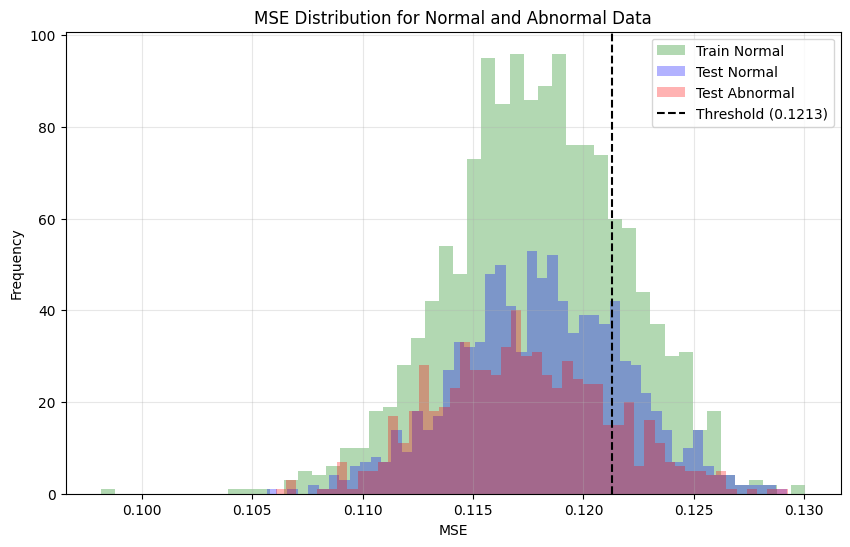

Evaluation process completed.


In [ ]:
# ==============================================================================
# Step 4: Model Evaluation
# ==============================================================================
import csv
import matplotlib.pyplot as plt
from prettytable import PrettyTable

print("\nStarting model evaluation...")
model_path = '/content/drive/MyDrive/model_train'

try:
    train_loss_file = os.path.join(model_path, 'train_normal_loss_sum_mse.csv')
    with open(train_loss_file, 'r') as f:
        data1 = [float(row[0]) for row in csv.reader(f) if row]
    if not data1:
        raise ValueError(f"No valid data found in {train_loss_file}")

    bb_t = np.array(data1)
    # The original script uses 80th percentile, but the text says 98th.
    # Sticking to the code logic, which is 80th percentile.
    thre = np.percentile(bb_t, 80)
    print(f"Computed 80th percentile threshold from training normal data: {thre:.4f}")

    normal_loss_file = os.path.join(model_path, 'normal_loss_sum_mse.csv')
    with open(normal_loss_file, 'r') as f:
        data = [float(row[0]) for row in csv.reader(f) if row]
    if not data:
        raise ValueError(f"No valid data found in {normal_loss_file}")
    bb = np.array(data)
    normal_true = bb[bb < thre]

    abnormal_loss_file = os.path.join(model_path, 'abnormal_loss_sum_mse.csv')
    with open(abnormal_loss_file, 'r') as f:
        data = [float(row[0]) for row in csv.reader(f) if row]
    if not data:
        raise ValueError(f"No valid data found in {abnormal_loss_file}")
    bb1 = np.array(data)
    abnormal_true = bb1[bb1 >= thre]

    normal_true_count = normal_true.shape[0]
    abnormal_true_count = abnormal_true.shape[0]
    normal_total = bb.shape[0]
    abnormal_total = bb1.shape[0]

    acc = (normal_true_count + abnormal_true_count) / (normal_total + abnormal_total) if (normal_total + abnormal_total) > 0 else 0
    precision_n = normal_true_count / (normal_true_count + (abnormal_total - abnormal_true_count)) if (normal_true_count + (abnormal_total - abnormal_true_count)) > 0 else 0
    precision_a = abnormal_true_count / (abnormal_true_count + (normal_total - normal_true_count)) if (abnormal_true_count + (normal_total - normal_true_count)) > 0 else 0
    pre_avg = (precision_a + precision_n) / 2
    recall_n = normal_true_count / normal_total if normal_total > 0 else 0
    recall_a = abnormal_true_count / abnormal_total if abnormal_total > 0 else 0
    recall_avg = (recall_a + recall_n) / 2
    F1 = 2 * (pre_avg * recall_avg) / (pre_avg + recall_avg) if (pre_avg + recall_avg) > 0 else 0

    x = PrettyTable(["Accuracy", "Precision (Normal)", "Precision (Abnormal)", "Precision (Avg)", "Recall (Normal)", "Recall (Abnormal)", "Recall (Avg)", "F1 Score"])
    x.add_row([f"{acc:.4f}", f"{precision_n:.4f}", f"{precision_a:.4f}", f"{pre_avg:.4f}", f"{recall_n:.4f}", f"{recall_a:.4f}", f"{recall_avg:.4f}", f"{F1:.4f}"])
    print("\nEvaluation Metrics:")
    print(x)

    output_file = os.path.join(model_path, 'evaluation_metrics.txt')
    with open(output_file, 'w') as f:
        f.write(f"80th Percentile Threshold (from training normal data): {thre:.4f}\n")
        f.write(str(x) + '\n')
    print(f"Saved evaluation metrics to: {output_file}")

    train_mse = np.loadtxt(train_loss_file)
    normal_mse = np.loadtxt(normal_loss_file)
    abnormal_mse = np.loadtxt(abnormal_loss_file)

    plt.figure(figsize=(10, 6))
    plt.hist(train_mse, bins=50, alpha=0.3, label='Train Normal', color='green')
    plt.hist(normal_mse, bins=50, alpha=0.3, label='Test Normal', color='blue')
    plt.hist(abnormal_mse, bins=50, alpha=0.3, label='Test Abnormal', color='red')
    plt.axvline(thre, color='black', linestyle='--', label=f'Threshold ({thre:.4f})')
    plt.xlabel('MSE')
    plt.ylabel('Frequency')
    plt.title('MSE Distribution for Normal and Abnormal Data')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plot_file = os.path.join(model_path, 'mse_distribution.png')
    plt.savefig(plot_file, dpi=300, bbox_inches='tight')
    print(f"Saved MSE distribution plot to: {plot_file}")
    plt.show()

except FileNotFoundError as e:
    print(f"Error: {e}")
except ValueError as e:
    print(f"Error: {e}")
except Exception as e:
    print(f"Unexpected error: {e}")

print("Evaluation process completed.")